# Notebook de préparation au modèle d'estimation

## Imports et paramètrage

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import seaborn as sns
#import numpy as np
import matplotlib.pyplot as plt
from classes.credentials import Credentials as cr
from classes.prediction import ImmothepPrediction
from classes.split import Splitter
from classes.isolation_forest import IsolationForestClass

splitter = Splitter()
isolation = IsolationForestClass()

In [2]:
valeurs2020 = pd.read_csv(cr.PATH+'2020.txt', sep='|', usecols=['Nature mutation', 'Code postal','Nombre pieces principales', 'Surface terrain', 'Valeur fonciere', 'Type local', 'Nombre de lots', 'Surface reelle bati'], encoding='utf-8')

## Nettoyage du dataset de biens immobiliers 2020
- Retirer les nuls
- Ploter
- Isolation forest

In [3]:
# Drop les lignes avec des nulles : type local, nombre lots, nb pièces, nature mutation, valeur foncière et CP
valeurs2020 = valeurs2020.dropna(subset = ['Type local', 'Nombre de lots', 'Nombre pieces principales', "Nature mutation", 'Valeur fonciere', 'Code postal'])

# On remplace les null de la surface de terrain par 0
valeurs2020['Surface terrain'] = valeurs2020['Surface terrain'].fillna(0) 

valeurs2020.head()

,Nature mutation,Valeur fonciere,Code postal,Nombre de lots,Type local,Surface reelle bati,Nombre pieces principales,Surface terrain
11,Vente,"72000,00",1270.0,0,Maison,35.0,2.0,381.0
13,Vente,"180300,00",1000.0,0,Maison,75.0,4.0,525.0
14,Vente,"54800,00",1000.0,2,Appartement,32.0,1.0,0.0
16,Vente,"350750,00",1000.0,0,Maison,201.0,7.0,1267.0
17,Vente,"350750,00",1000.0,0,Maison,201.0,7.0,1497.0


In [4]:
# Premier tri, on garde les appartements et maisons, les ventes, un nombre de pièces principales supérieur à 0, 
# un nombre de lots inférieur à 6, surface réelle bâtie supérieure à 8 (minimum légal)
valeurs2020 = valeurs2020[[
    'Type local',
    'Code postal', 
    'Nombre pieces principales', 
    'Surface terrain', 
    'Surface reelle bati',
    'Valeur fonciere'
    ]][valeurs2020['Type local'].str.contains("Appartement|Maison", regex=True)][valeurs2020['Nature mutation'].str.contains("Vente", regex=True)][valeurs2020['Nombre de lots']<6][valeurs2020['Nombre pieces principales']>0][valeurs2020['Surface reelle bati']>=8]


C:\Users\audre\AppData\Local\Temp/ipykernel_22348/2911758537.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valeurs2020 = valeurs2020[[


In [5]:
valeurs2020.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 915817 entries, 11 to 2459557
Data columns (total 6 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Type local                 915817 non-null  object 
 1   Code postal                915817 non-null  float64
 2   Nombre pieces principales  915817 non-null  float64
 3   Surface terrain            915817 non-null  float64
 4   Surface reelle bati        915817 non-null  float64
 5   Valeur fonciere            915817 non-null  object 
dtypes: float64(4), object(2)
memory usage: 48.9+ MB


In [6]:
# Changement des virgules en points
valeurs2020[['Valeur fonciere']] = valeurs2020[['Valeur fonciere']].replace(',', '.', regex=True)

# Passage des objets en floats
valeurs2020[['Valeur fonciere']]  = valeurs2020[['Valeur fonciere']].astype('float')

valeurs2020.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 915817 entries, 11 to 2459557
Data columns (total 6 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Type local                 915817 non-null  object 
 1   Code postal                915817 non-null  float64
 2   Nombre pieces principales  915817 non-null  float64
 3   Surface terrain            915817 non-null  float64
 4   Surface reelle bati        915817 non-null  float64
 5   Valeur fonciere            915817 non-null  float64
dtypes: float64(5), object(1)
memory usage: 48.9+ MB


In [7]:
# Séparation des maisons et appartements
valeursMaisons = valeurs2020[valeurs2020['Type local'].str.contains("Maison", regex=True)]
valeursApparts = valeurs2020[valeurs2020['Type local'].str.contains("Appartement", regex=True)]

In [8]:
nancount = valeursMaisons.isna()
print (nancount.sum())
# valeurs2020 = valeurs2020.dropna(subset = ['Valeur fonciere'])
# nancount = valeurs2020["Valeur fonciere"].isna()

Type local                   0
Code postal                  0
Nombre pieces principales    0
Surface terrain              0
Surface reelle bati          0
Valeur fonciere              0
dtype: int64


In [9]:
# Import en CSV dans src/data/currated
valeursMaisons.to_csv(cr.CURATED_LOCAL_PATH + 'filtreMaisons2020.csv', index=False)
valeursApparts.to_csv(cr.CURATED_LOCAL_PATH + 'filtreAppart2020.csv', index=False)

## Split du dataset en départements

In [10]:
# Split des données par type de logement et par département
splitter.split_datas('filtreMaisons2020.csv', 'Code postal', 'CPMaisons')
splitter.split_datas('filtreAppart2020.csv', 'Code postal', 'CPAppart')

## Test de l'isolation forest sur le dataset du puy-de-dome

In [11]:
valeursMaisons63 = pd.read_csv(cr.CURATED_LOCAL_PATH + '/CPMaisons/63.csv', sep='|', encoding='utf-8')
valeursMaisons63.head()

,Type local,Code postal,Nombre pieces principales,Surface terrain,Surface reelle bati,Valeur fonciere
0,Maison,63950.0,3.0,580.0,68.0,40000.0
1,Maison,63950.0,3.0,400.0,68.0,40000.0
2,Maison,63950.0,4.0,0.0,100.0,30000.0
3,Maison,63950.0,2.0,1670.0,39.0,30000.0
4,Maison,63950.0,2.0,500.0,39.0,30000.0


In [12]:
isolation.isolation_forest_testing(cr.CURATED_LOCAL_PATH + '/CPMaisons/63.csv', cr.CURATED_LOCAL_PATH + '/CPMaisons/63_IF.csv')

   Type local  Code postal  Nombre pieces principales  Surface terrain  \
0      Maison      63950.0                        3.0            580.0   
1      Maison      63950.0                        3.0            400.0   
2      Maison      63950.0                        4.0              0.0   
3      Maison      63950.0                        2.0           1670.0   
4      Maison      63950.0                        2.0            500.0   
5      Maison      63950.0                        3.0            600.0   
6      Maison      63950.0                        3.0            530.0   
7      Maison      63950.0                        3.0            490.0   
8      Maison      63950.0                        4.0            710.0   
10     Maison      63580.0                        3.0            500.0   

    Surface reelle bati  Valeur fonciere    scores  anomaly  
0                  68.0          40000.0  0.022529        1  
1                  68.0          40000.0  0.024163        1  

In [13]:
# Import du CSV avec le score de l'IF
valeursMaisons63_if = pd.read_csv(cr.CURATED_LOCAL_PATH + '/CPMaisons/63_IF.csv', usecols=['Type local', 'Nombre pieces principales', 'Surface terrain', 'Surface reelle bati', 'Valeur fonciere', 'scores', 'anomaly'])
valeursMaisons63_if.head()

,Type local,Nombre pieces principales,Surface terrain,Surface reelle bati,Valeur fonciere,scores,anomaly
0,Maison,3.0,580.0,68.0,40000.0,0.022529,1
1,Maison,3.0,400.0,68.0,40000.0,0.024163,1
2,Maison,4.0,0.0,100.0,30000.0,0.021922,1
3,Maison,2.0,1670.0,39.0,30000.0,-0.062316,-1
4,Maison,2.0,500.0,39.0,30000.0,-0.030907,-1


In [14]:
# Vérification du nombre de valeurs
print("valeursMaisons63_if ", len(valeursMaisons63_if), " rows")
print("Anomalies ", len(valeursMaisons63_if[valeursMaisons63_if['anomaly']==-1]), " rows")

valeursMaisons63_if  300  rows
Anomalies  56  rows


In [15]:
# Suppression des anomalies
valeursMaisons63_if = valeursMaisons63_if[['Type local', 'Nombre pieces principales', 'Surface terrain', 'Surface reelle bati', 'Valeur fonciere']][valeursMaisons63_if["anomaly"] != -1]

<AxesSubplot:>

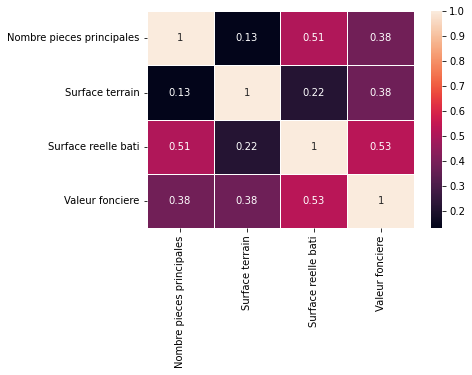

In [16]:
# Correlation
data_corr_train = valeursMaisons63_if.corr()
sns.heatmap(data_corr_train, linewidths=.5, annot=True)

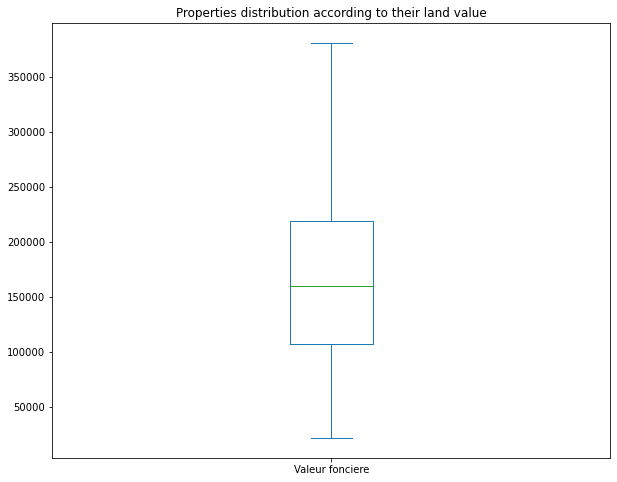

In [17]:
valeursMaisons63_if['Valeur fonciere'].plot(kind = 'box', title = 'Properties distribution according to their land value', figsize = (10, 8))
plt.show()

array([[<AxesSubplot:title={'center':'Valeur fonciere'}>]], dtype=object)

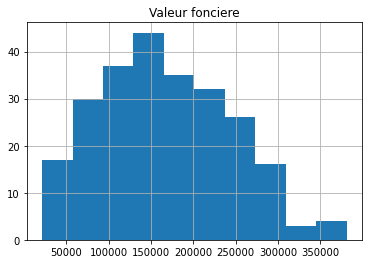

In [18]:
valeursMaisons63_if.hist(column='Valeur fonciere')

## Test de la méthode d'isolation forest définitive

In [19]:
# dataTest = pd.read_csv(cr.CURATED_LOCAL_PATH + "CPAppart/75.csv", sep="|", encoding="utf-8")

## Faire tourner l'Isolation Forest sur tous les csv

## Etalonage d'un modèle de régression linéaire

In [38]:
from classes.linear_regression import Linear_reg

In [39]:
# Instanciation du modèle
linear_reg = Linear_reg()

# Split en train et test sets
train_features, test_features, train_labels, test_labels = linear_reg.train_test_split('63_IF', 'maison')

In [40]:
# Entrainnement du modèle
linear_reg.train(train_features, train_labels)

## Test du modèle

In [41]:
linear_reg.get_metrics(test_features, test_labels)

Mean squared error:  4436960092.255547 
Variance regression score function:  0.553713252893057 
Maximum residual error:  201079.13925297803 
Mean absolute error regression loss:  50552.882261494065


In [42]:
# Prédictions sur un jeu de test
test_set = pd.read_csv(cr.CURATED_LOCAL_PATH + "/CPMaisons/3.csv", sep="|", usecols=['Nombre pieces principales', 'Surface terrain', 'Surface reelle bati'], encoding="utf-8")
test_set = test_set.dropna()

test_set_labels = pd.read_csv(cr.CURATED_LOCAL_PATH + "/CPMaisons/3.csv", sep="|", usecols=['Nombre pieces principales', 'Surface terrain', 'Surface reelle bati', 'Valeur fonciere'], encoding="utf-8")
test_set_labels = test_set_labels.dropna()

linear_reg.predict(test_set)
test_set.head()


,Nombre pieces principales,Surface terrain,Surface reelle bati,Valeur fonciere estimee
0,1.0,1625.0,53.0,163981.799720
1,2.0,100.0,56.0,110593.701774
2,4.0,153.0,96.0,179677.862546
3,6.0,560.0,157.0,296500.378300
4,6.0,753.0,130.0,260375.792129


In [43]:
test_set_labels.head()

,Nombre pieces principales,Surface terrain,Surface reelle bati,Valeur fonciere
0,1.0,1625.0,53.0,81775.0
1,2.0,100.0,56.0,30000.0
2,4.0,153.0,96.0,34000.0
3,6.0,560.0,157.0,102500.0
4,6.0,753.0,130.0,113000.0


In [44]:
print(linear_reg.predict_value(104.0, 4.0, 595.0))

[1098526.68576985]
